### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
from statistics import mean
from math import e
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

pd.options.mode.chained_assignment = None  # default='warn'

### Definition of Functions

In [1]:
def create_hep_data(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight'])

    for key, item in input_df.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        starttime_rate = []
        rate_by_weight = []

        for i in range(len(item)):
            starttime_rate.append(item.iloc[i,1]) 
            rate_by_weight.append(item.iloc[i,3])

            if i == len(item)-1:
                starttime_rate.append(item.iloc[i,2])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': starttime_rate,
            'rate_by_weight': rate_by_weight},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def create_ptt_data(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','rel_charttime'])

    for key, item in input_df.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        rel_charttime = []

        for i in range(len(item)):
            rel_charttime.append(item.iloc[i,1]) 

        output_df = output_df.append({
            'stay_id': key,
            'rel_charttime': rel_charttime},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def insert_data(input_hep,input_ptt):
    
    #Insertions will be made on output_data
    output_data = input_hep
    
    for key, row in input_ptt.iterrows():
    
        for i in range(len(row['rel_charttime'])):

            new_time_entry       = row['rel_charttime'][i]
            new_time_entry_idx   = np.nan
            new_rate_entry       = np.nan
            new_rate_entry_idx   = np.nan

            # Find index in starttime_rate, where new_entry is inserted
            for j in range(len(output_data.loc[key,'starttime_rate'])-1):
                if new_time_entry >= output_data.loc[key,'starttime_rate'][j] and new_time_entry < output_data.loc[key,'starttime_rate'][j+1]:
                    new_time_entry_idx = j+1
                    new_rate_entry_idx = j+1
                    new_rate_entry = output_data.loc[key,'rate_by_weight'][j]
                if j == (len(output_data.loc[key,'starttime_rate'])-2) and new_time_entry > output_data.loc[key,'starttime_rate'][j+1]:
                    new_time_entry_idx = j+2
                    new_rate_entry_idx = j+1
                    new_rate_entry = 0
                    
            if np.isnan(new_time_entry_idx) or np.isnan(new_rate_entry_idx) or np.isnan(new_rate_entry):
                continue
                #print("nan Input")
            else:
                output_data.loc[key,'starttime_rate'].insert(new_time_entry_idx, new_time_entry)
                output_data.loc[key,'rate_by_weight'].insert(new_rate_entry_idx, new_rate_entry)
            
    return output_data

def add_pharmacokinetics_30min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-2*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_45min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-1.33*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_60min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-1*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_120min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-0.5*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_concentration_to_ptt_data(input_df):
    
    query_ptt = """
                SELECT *
                FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
                WHERE rel_charttime BETWEEN 0 AND 1440
                """
    df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")
    
    df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
    df_ptt['rel_charttime'] = df_ptt['rel_charttime'].div(60).round(2)
    
    final_df = pd.DataFrame(columns=['stay_id','rel_charttime','PTT','rate_by_weight','hep_concentration'])

    for key, item in df_ptt.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        for i in range(len(item)):

            idx = np.nan

            for j in range(len(input_df.loc[key,'starttime_rate'])):

                if item.iloc[i,1] == input_df.loc[key,'starttime_rate'][j]:
                    idx = j
                
            final_df = final_df.append({
                'stay_id': key,
                'rel_charttime': item.iloc[i,1],
                'PTT': item.iloc[i,2],
                'rate_by_weight': input_df.loc[key,'rate_by_weight'][idx-1],
                'hep_concentration': input_df.loc[key,'hep_concentration'][idx]
            }, ignore_index=True) 

    final_df = final_df.astype({'stay_id':int})
    final_df.set_index('stay_id', inplace=True)
    
    return(final_df)

### Presentation of Logic

In [5]:
query_hep = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data_preprocessed`
            ORDER BY subject_id, stay_id, rel_starttime
            """
query_ptt = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
            WHERE rel_charttime BETWEEN 0 AND 1440
            """
df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")
df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

df_hep = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
df_hep = df_hep.sort_values(by=['stay_id','rel_starttime'], ascending=True)
df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
df_ptt = df_ptt.sort_values(by=['stay_id','rel_charttime'], ascending=True)

print("df_hep:\n")
print(df_hep.head(10))
print("\n df_ptt:\n")
print(df_ptt.head(10))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:04<00:00, 3741.84rows/s]

df_hep:

        stay_id  rel_starttime  rel_endtime  rate_by_weight
4709   30001336              0         1497           12.99
19307  30006731              0          369           17.91
19308  30006731            369          421            0.00
19309  30006731            421          830           14.19
19310  30006731            830         1582           10.46
14331  30007565              0          452           11.79
14332  30007565            452          777            9.43
14333  30007565            777         1005            6.60
14334  30007565           1005         1440            0.00
12665  30009339              0          292           12.50

 df_ptt:

        stay_id  rel_charttime    PTT
3441   30001336              5   60.5
3442   30001336            338   59.9
14292  30006731            284  138.9
14293  30006731            702  150.0
14294  30006731           1168   90.2
10592  30007565            439  108.0
10593  30007565            707  131.2
9326   30009339 

In [6]:
hep_data = create_hep_data(df_hep)
print("\n hep_data: df_hep converted, to have better access via key:stay_id \n")
print(hep_data.head(10))

ptt_data = create_ptt_data(df_ptt)
print("\n ptt_data: df_ptt converted, to have better access via key:stay_id \n")
print(ptt_data.head(10))


 hep_data: df_hep converted, to have better access via key:stay_id 

                                starttime_rate  \
stay_id                                          
30001336                             [0, 1497]   
30006731              [0, 369, 421, 830, 1582]   
30007565             [0, 452, 777, 1005, 1440]   
30009339       [0, 292, 733, 1213, 1257, 1440]   
30009505         [0, 74, 479, 893, 1123, 1720]   
30015055  [0, 360, 899, 975, 1046, 1161, 1440]   
30016014                  [0, 346, 1121, 1440]   
30016345          [0, 72, 247, 699, 964, 1440]   
30016557                        [0, 964, 1961]   
30017473            [0, 607, 1108, 1228, 1824]   

                                 rate_by_weight  
stay_id                                          
30001336                                [12.99]  
30006731             [17.91, 0.0, 14.19, 10.46]  
30007565                [11.79, 9.43, 6.6, 0.0]  
30009339         [12.5, 15.0, 17.49, 17.5, 0.0]  
30009505    [10.96, 13.95, 13

In [7]:
# Be careful: only execute once (otherwise there will be duplicate insertions)
hep_data = insert_data(hep_data,ptt_data)
print("\n hep_data, after inserting timestamps of PTT measurements \n")
print(hep_data.head(10))


 hep_data, after inserting timestamps of PTT measurements 

                                             starttime_rate  \
stay_id                                                       
30001336                                  [0, 5, 338, 1497]   
30006731           [0, 284, 369, 421, 702, 830, 1168, 1582]   
30007565                [0, 439, 452, 707, 777, 1005, 1440]   
30009339    [0, 169, 292, 691, 733, 1036, 1213, 1257, 1440]   
30009505      [0, 74, 404, 479, 823, 893, 1123, 1270, 1720]   
30015055  [0, 325, 360, 680, 831, 899, 975, 1046, 1161, ...   
30016014                     [0, 271, 346, 789, 1121, 1440]   
30016345                  [0, 72, 247, 652, 699, 964, 1440]   
30016557                           [0, 323, 706, 964, 1961]   
30017473                         [0, 607, 1108, 1228, 1824]   

                                             rate_by_weight  
stay_id                                                      
30001336                              [12.99, 12.99, 12.99

In [8]:
# Be careful: only execute once!
complete_df = add_pharmacokinetics_60min(hep_data)
print("\n calculation of hep_concentration for any timestamp in 'starttime_rate': \n")
print(complete_df.head(10))


 calculation of hep_concentration for any timestamp in 'starttime_rate': 

                                             starttime_rate  \
stay_id                                                       
30001336                           [0.0, 0.08, 5.63, 24.95]   
30006731  [0.0, 4.73, 6.15, 7.02, 11.7, 13.83, 19.47, 26...   
30007565       [0.0, 7.32, 7.53, 11.78, 12.95, 16.75, 24.0]   
30009339  [0.0, 2.82, 4.87, 11.52, 12.22, 17.27, 20.22, ...   
30009505  [0.0, 1.23, 6.73, 7.98, 13.72, 14.88, 18.72, 2...   
30015055  [0.0, 5.42, 6.0, 11.33, 13.85, 14.98, 16.25, 1...   
30016014              [0.0, 4.52, 5.77, 13.15, 18.68, 24.0]   
30016345        [0.0, 1.2, 4.12, 10.87, 11.65, 16.07, 24.0]   
30016557                   [0.0, 5.38, 11.77, 16.07, 32.68]   
30017473                   [0.0, 10.12, 18.47, 20.47, 30.4]   

                                             rate_by_weight  \
stay_id                                                       
30001336                              [12

Text(0, 0.5, 'hep_concentration')

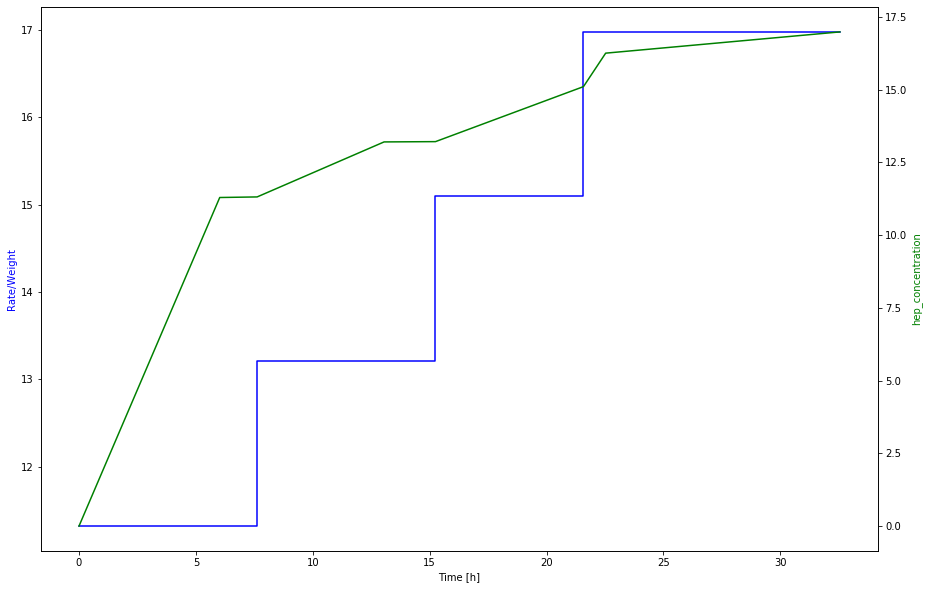

In [9]:
# Visualize Information in complete_df
fig, ax = plt.subplots(figsize=(15,10))

axes = [ax, ax.twinx()]

x_values = []
y_values = []

stay_id = 33685454

for i in range(len(complete_df.loc[stay_id,'starttime_rate'])-1):
    x_values.append(complete_df.loc[stay_id,'starttime_rate'][i])
    x_values.append(complete_df.loc[stay_id,'starttime_rate'][i+1])
    y_values.append(complete_df.loc[stay_id,'rate_by_weight'][i])
    y_values.append(complete_df.loc[stay_id,'rate_by_weight'][i])

    
axes[0].plot(x_values, y_values, color='b')
axes[0].set_xlabel('Time [h]')
axes[0].set_ylabel('Rate/Weight', color='b')
axes[1].plot(complete_df.loc[stay_id,'starttime_rate'], complete_df.loc[stay_id,'hep_concentration'], color='g')
axes[1].set_ylabel('hep_concentration', color='g')

In [10]:
final_df = add_concentration_to_ptt_data(complete_df)
print("\n final dataframe, that attaches information about hep_concentration to any given PTT-measurement: \n")
print(final_df.head(10))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:04<00:00, 3628.21rows/s]



 final dataframe, that attaches information about hep_concentration to any given PTT-measurement: 

          rel_charttime    PTT  rate_by_weight  hep_concentration
stay_id                                                          
30001336           0.08   60.5           12.99               1.00
30001336           5.63   59.9           12.99              12.94
30006731           4.73  138.9           17.91              17.75
30006731          11.70  150.0           14.19              14.13
30006731          19.47   90.2           10.46              10.47
30007565           7.32  108.0           11.79              11.78
30007565          11.78  131.2            9.43               9.46
30009339           2.82   36.1           12.50              11.75
30009339          11.52   38.2           15.00              15.00
30009339          17.27   36.6           17.49              17.47


C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


AVG R2-Score:  0.1264
EXAMPLE R2-Score:  0.142


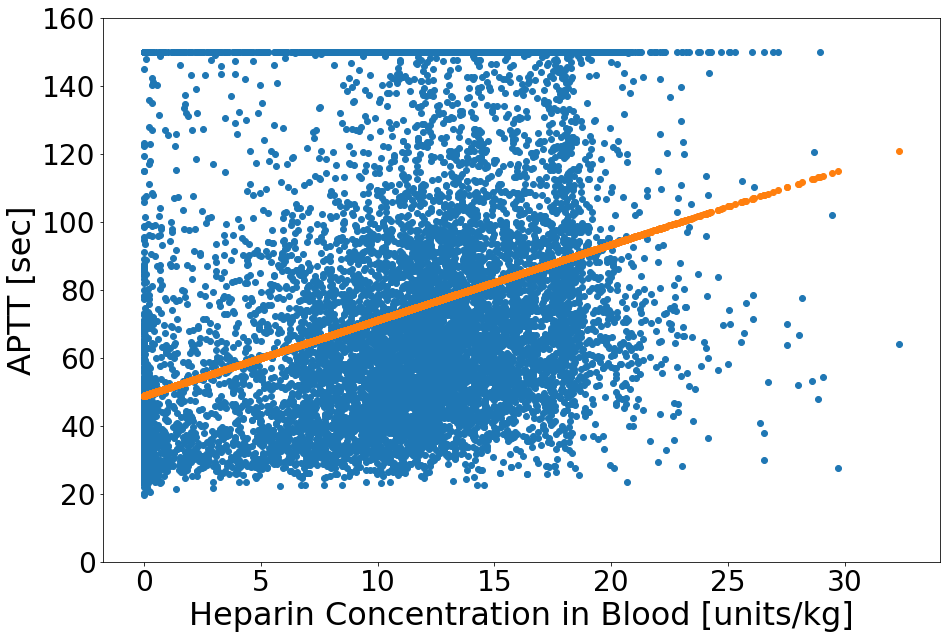

In [13]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1, 1)
y = np.array([final_df['PTT']]).reshape(-1, 1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp)
y = np.delete(y,temp)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
                  
# Determine Average Performance (n=100)
r2_scores = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    r2_scores.append(r2_score(y_test, lin_reg.predict(x_test)))

# Evaluate the Model
print("AVG R2-Score: ", round(mean(r2_scores),4))


# EXAMPLE

                  
# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Heparin Concentration in Blood [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the Example:
print("EXAMPLE R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))